# Elementmetoden

## Del 1: Fagverk, innføring

Vi skal begynne å se på en viktig anvendelse av data i ingeniørfag, nemlig elementmetoden. Det er en teknikk som reduserer kompliserte problemer til matematiske ligninger slik vi ser i matematikk 1, f eks lineære systemer. Elementmetoden omfatter flere relatert teknikker, og for å holde orden over koden er objekt-orientert programmering ofte nyttig.

Typisk krever vi både geometrisk og matematisk data, som egner seg godt til implementering som klasser. Et enkelt eksempel ser studenter som tar mekanikk 1, f eks bygg- og maskiningeniører. Det er 2-dimensjonale fagverk. Under ligger en bro, som danner geometrien til systemet. Koden som følger er skrevet av en matematiker og følger slett ikke god praksis!

<Figure size 432x288 with 0 Axes>

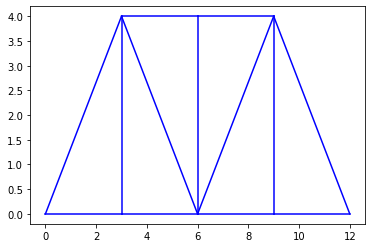

In [1]:
import matplotlib.pyplot as plt
import numpy as np

n=1
m=2*(n+1)

B = np.zeros((2*m,2))

jevn = np.arange(2,2*m,2)
odde = np.arange(1,2*m,2)

B[odde,0] = 3*np.arange(1,m+1)
B[odde,1] = np.zeros(m)
B[jevn,0] = 3*np.arange(1,m)
B[jevn,1] = 4+np.zeros(m-1)

TLeft = np.array([[1,2],[1,3],[2,3]])
TRight = np.array([[1,3],[2,3]])
SDLeft = np.array([[1,3],[1,4],[2,4],[3,4]])
SDRight = np.array([[1,3],[2,3],[2,4],[3,4]])
SFull = np.array([[1,3],[1,4],[2,3],[2,4],[3,4]])

grunn = 1+2*np.arange(n)

A = TLeft
for i in grunn:
    A = np.concatenate([A,i+SDRight])
    
for j in grunn:
    A = np.concatenate([A,1+j+i+SDLeft])
    
A = np.concatenate([A,3+i+j+TRight])-1

fig = plt.figure()

fig, ax = plt.subplots()

for k in A:
    ax.plot(np.transpose(B[k,0]),np.transpose(B[k,1]), color='b')

Ser vi nøyere på eksempel, består det av en matrise B som inneholder koordinatene til alle noder (knutepunkter), samt en matrise A som er en liste av staver fra et knutepunkt til et annet (f eks [0,1] er en stav som kobler knutepunkt 0 til knutepunkt 1).

Det vi ønsker å gjøre er å finne strekk/trykk i alle staver slik at knutepunkter står i ro. Det er et lineært system av type $L \vec{u} = \vec{f}$, hvor vi kan kalle $L$ for en stivhetsmatrise. Litt mer forklaring:
1. $\vec{u}=(u_1,u_2,\ldots)$ er en vektor hvor $u_i$ er strekk/trykk i stav nummer $i$.
2. $\vec{f}=(f_{1x}, f_{1y}, f_{2x}, f_{2y}, \ldots)$ er en vektor med $2m$ komponenter, hvor $m$ er antall noder, som inneholder eksterne krefter i $x$- og $y$-retninger på hver node.
3. $L_{ij}$ er en matrise hvor $i=1,\ldots,2m$ er node/retning (som i kreft-vektoren) og $j=1,\ldots,n$ er stavnummeret (som i strekk/trykk-vektoren). Komponenten $(i,j)$ er lik
* $\cos(\theta)$ hvis $i$ er en $x$-retning og stav $j$ er knyttet til node $i$, og har vinkel $\theta$ med $x$-aksen,
* $\sin(\theta)$ hvis $i$ er en $y$-retning og stav $j$ er knyttet til node $i$, og har vinkel $\theta$ med $x$-aksen,
* $0$ hvis ikke stav $j$ er knyttet til node $i$.

En ekstra komplikasjon er at det finnes randbetingelser, dvs noder som er festet til bakken i en eller flere retninger. De funker som usynlige staver, dvs indexen $j$ kan være en slik "reaksjonskraft" (i tillegg til en stav). For en slik $j$ er
* $f_j=0$
* $L_{ij}=1$ hvis $i$ er festet til bakken i retningen som innegår i $i$
* $L_{ij}=0$ ellers

In [2]:
C = np.zeros(2)
for k in A:
    v = B[k[1],:]-B[k[0],:]
    v = v/np.linalg.norm(v)
    C = np.vstack([C,v])
C = np.delete(C,0,0)

L=np.zeros([4*m,4*m])

for l in np.arange(np.size(A,0)):
    L[2*A[l,0],l] = C[l,0]
    L[2*A[l,0]+1,l] = C[l,1]
    L[2*A[l,1],l] = C[l,0]
    L[2*A[l,1]+1,l] = C[l,1]
    
q = np.size(A,0)    
    
L[0,q]=1
L[1,q+1]=1
L[4*m-1,q+2]=1

Vi setter opp vektoren på høyre siden ved å bestemme oss for at enkle knutepunktene er holdt i ro ved eksterne krefter. Den første noden holdes i ro ved krefter i den vertikale og den horizontale retningen, mens den siste holdes i ro kun ved en kreft i den vertikale retningen.

In [3]:
F=np.zeros([4*m,1])

F[3,0]=12
F[7,0]=20
F[11,0]=12

strekk = np.linalg.solve(L,F)

print(strekk)

[[ 16.5]
 [-27.5]
 [ 12. ]
 [-16.5]
 [-12.5]
 [ 24. ]
 [  0. ]
 [ 16.5]
 [ 12.5]
 [-24. ]
 [ 12. ]
 [-16.5]
 [ 27.5]
 [  0. ]
 [ 22. ]
 [ 22. ]]


# Del 2: En ny klasse

Målet nå er å lage et program som koder 2d fagverk på en mer robust, objekt-orientert måte, slik at det kan i senere tid lett adapteres.

Under har vi kodet en ny klasse, Mesh, som skal håndtere den geometriske dataen $(A,B)$. Målet er at i fremtid det skal kunne bli brukt til forskjellige geometrier, f. eks. trekanter istedet for staver, og at det skal kunne funke i 3-dimensjoner også.

In [4]:
from copy import copy
from math import sqrt

In [5]:
class Mesh:
   
    def __init__(self):
        self._knutepunktPosisjon = []
        self._staver = []        
   
    def __str__(self):
        return "Antall knutepunkt = " + str(self.antallKnutepunkt()) + "\n" + \
               "Knutepunktposisjoner = " + str(self._knutepunktPosisjon) + "\n" + \
               "Antall staver = " + str(self.antallStaver()) + "\n" + \
               "Staver = " + str(self._staver)          
                       
    # Antall knutepunkt i modellen    
    def antallKnutepunkt(self):
        return len(self._knutepunktPosisjon)
                   
    # Setter posisjonen til et knutepunkt        
    def settKnutepunktPosisjon(self, knutepunktIndex, nyPosisjon):
        self._knutepunktPosisjon[knutepunktIndex] = nyPosisjon
       
    # Legger til knutepunkt
    def leggTilKnutepunkt(self, posisjon):
        self._knutepunktPosisjon.append(posisjon)      

    # finner posisjonen til et knutepunkt
    def knutepunktPosisjon(self, knutepunktIndex):
        return self._knutepunktPosisjon[knutepunktIndex]

    # legger til en liste med flere staver        
    def leggTilFlereStaver(self, listeKnutepunkter):
        self._staver += listeKnutepunkter
       
    # Gir antall staver
    def antallStaver(self):
        return len(self._staver)
       
    # Endrer knutepunktene til en stav    
    def endreKnutepunktTilStav(self, stavIndex, knutepunkt):
        self._stav[stavIndex] = knutepunkt        
       
    # Gir knutepunktet til en stav
    def knutepunktTilStav(self, stavIndex):
        return self._staver[stavIndex]
   

       

## Oppgave 1:

Noen metoder mangler. Fyll dem ut selv.

In [6]:
    # legg til liste med nye knutepunkt        
    def leggTilFlereKnutepunkt(self, posisjon):
    # mangler
        
           
    # legger til en stav
    def leggTilStav(self, knutepunkter):
    # mangler
    
    # Gir en liste med de stavene som er koblet til et knutepunkt
    def staverInnTilKnutepunkt(self, knutepunktIndex):
    # mangler

IndentationError: expected an indented block (<ipython-input-6-06b777220754>, line 7)

Her kommer en iterator.

In [ ]:
class MeshIter:
   
    def __init__(self, mesh):
        self._start = 0;
        self._mesh = mesh
        self._stop = self._mesh.antallStaver() - 1
        self._num = 0
       
    def __iter__(self):
        return self
       
    def __next__(self):
        if self._num > self._stop:
            raise StopIteration
        else:
            self._num += 1
            return self._mesh.knutepunktTilStav(self._num-1)

## Oppgave 2:

Det finnes mangler i funksjonen som lager Stivhetsmatrisa. Fyll ut.

In [ ]:
import numpy as np
       
def lagStivhetsmatrise(mesh, knutepunktFastX, knutepunktFastY):
    m = mesh.antallKnutepunkt()
    matrise = np.zeros((2*m, 2*m))
    n = 0
    for stav in MeshIter(mesh):
        # mangler
    for i in knutepunktFastX:
        # mangler
    for i in knutepunktFastY:
        # mangler
    return matrise


## Oppgave 3:

Løs sytemet fra innføringen ved å bruke koden under.

In [ ]:
mesh = Mesh()
mesh.leggTilFlereKnutepunkt([[ 0. , 0.], [ 3.,  0.], [ 3.,  4.], [ 6. , 0.], [ 6. , 4.], [ 9.,  0.], [ 9. , 4.], [12.,  0.]])
mesh.leggTilFlereStaver([[0, 1], [0, 2], [1, 2], [1, 3], [2, 3], [2, 4], [3, 4], [3, 5], [3, 6], [4, 6], [5, 6], [5, 7], [6, 7]])

print(mesh)

L = lagStivhetsmatrise(mesh, [0], [0,7])

# mangler

## Oppgave 4:

Koden er fortsett verken pen eller robust.

1. Hva hvis noen bruker klassen feil, f eks kobler en stav til en node som ikke finnes. Legg inn feilsjekk i "leggTilFlereStaver" og "leggTilStav"
2. Koden er veldig dårlig kommentert, så utvid med gode kommentarer. 
 
